### <u>Introduction</u>

The purpose of this project is to make accurate salary preditctions that are based on known salaries so the company is able to recruit and retain top talent. This model will serve as a guide for offering competetive compensation to existing and future employees while controlling payroll expenses.

Data transformation and machine learning will be used to create a model that will predict a salary when given years of experience, job type, college degree, college major, industry, and miles from a metropolis.

### <u>Data</u>

The data for this model is fairly simplified as it has very few missing pieces. The raw data consists of a training dataset with the features listed above and their corresponding salaries. Twenty percent of this training dataset was split into a test dataset with corresponding salaries so accuracy and error of the model can be determined.

There is also a testing dataset that does not have any salary information available and was used as a substitute for real-world data.

#### <u>Information Used To Predict Salaries Explained:</u>
* <b>Years Experience:</b> How many years of experience
* <b>Job Type:</b> The position held (CEO, CFO, CTO, Vice President, Manager, Janitor, and senior or junior position)
* <b>College Degree:</b> Doctoral, Masters, Bachelors, High School, or None
* <b>College Major:</b> Biology, Business, Chemistry, Computer Science, Engineering, Literature, Math, Physics, or None
* <b>Industry:</b> Auto, Education, Finance, Health, Oil, Service, or Web
* <b>Miles From Metropolis:</b> How many miles away from a major city

### <u>Import Libraries</u>

In [ ]:
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib


### <u> Define Functions</u>

In [ ]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, title):
    width = 10
    height=6
    plt.figure(figsize=(width, height))

    ax1=sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2=sns.distplot(BlueFunction, hist=False, color="b", label=BlueName)

    plt.title(title)
    plt.xlabel("Proportion of Jobs")
    plt.ylabel("Salary (in thousand dollars)")
    plt.show()
    plt.close()

In [ ]:
def PollyPlot(X_train, X_test, y_train, y_test, lr, poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    xmax = max([X_train.values.max(), X_test.values.max()])
    xmin = min([X_train.values.min(), X_test.values.min()])
    x = np.arange(xmin, xmax, 0.1)

    plt.plot(X_train, y_train, 'ro', label='Training Data')
    plt.plot(X_test, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predict Function')
    plt.ylim(-100, 5000)
    plt.ylabel('Salary')
    plt.legend

In [ ]:
def ViolinPlot(data, var):
    data = pd.concat([train_data['salary'], train_data[var]], axis=1)
    f, ax = plt.subplots(figsize=(12, 8))
    fig = sns.violinplot(x=var, y='salary', data=data, scale='count', inner='quartile')
    plt.xticks(rotation=75)

## <br> Data Preparation

### <u> Load The Data</u>

Load data into a Pandas dataframe and check the first five rows:

In [ ]:
# Load raw data
train_feat = pd.read_csv('/Users/DJ/Salary-Prediction-Portfolio/data/train_features.csv')
train_sal = pd.read_csv('/Users/DJ/Salary-Prediction-Portfolio/data/train_salaries.csv')
test_feat = pd.read_csv('/Users/DJ/Salary-Prediction-Portfolio/data/test_features.csv')

# Verify data is loaded
train_feat.head()

jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  milesFromMetropolis  
0   HEALTH               10                   83  
1      WEB                3                   73  
2   HEALTH               10                   38  
3     AUTO                8                   17  
4  FINANCE                8                   16

In [ ]:
# Verify data is loaded
train_sal.head()

jobId  salary
0  JOB1362684407687     130
1  JOB1362684407688     101
2  JOB1362684407689     137
3  JOB1362684407690     142
4  JOB1362684407691     163

In [ ]:
# Verify data is loaded
test_feat.head()

jobId companyId  jobType       degree    major industry  \
0  JOB1362685407687    COMP33  MANAGER  HIGH_SCHOOL     NONE   HEALTH   
1  JOB1362685407688    COMP13   JUNIOR         NONE     NONE     AUTO   
2  JOB1362685407689    COMP10      CTO      MASTERS  BIOLOGY   HEALTH   
3  JOB1362685407690    COMP21  MANAGER  HIGH_SCHOOL     NONE      OIL   
4  JOB1362685407691    COMP36   JUNIOR     DOCTORAL  BIOLOGY      OIL   

   yearsExperience  milesFromMetropolis  
0               22                   73  
1               20                   47  
2               17                    9  
3               14                   96  
4               10                   44

### <u>Clean The Data</u>

Check the shape of the dataframes:

In [ ]:
print(train_feat.shape)
print(train_sal.shape)
print(test_feat.shape)

(1000000, 8)
(1000000, 2)
(1000000, 8)


The data in train_feat and test_feat have the same features. The test_feat dataset will be good for testing created models without any pre-existing salary information and will be used in place of "real world" data to predict salaries.

The data in the train_sal dataset only contains salaries and job IDs. These job IDs correspond to the job IDs in the train_feat dataset. These training datasets will be combined into one datafame by joining matching job IDs.



Join the training dataframes by matching job ID and check merged data:

In [ ]:
train_data = pd.merge(train_feat, train_sal, on ='jobId')

# Check features of merged data
train_data.head()

jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  milesFromMetropolis  salary  
0   HEALTH               10                   83     130  
1      WEB                3                   73     101  
2   HEALTH               10                   38     137  
3     AUTO                8                   17     142  
4  FINANCE                8                   16     163

In [ ]:
# Check shape of new dataframe
train_data.shape

(1000000, 9)


The shape and features of the train_data dataset are correct. Next, we will look for any missing data.

In [ ]:
# Check for missing data
missing_data = train_data.isnull().sum()
missing_data

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64


None of the columns contain missing data.

<br>
The next step is to find salaries that are not useful for prediction purposes, such as negative numbers or salaries of zero.

In [ ]:
# Check for invalid salaries
zero_salary = train_data['salary']<=0
invalid_salary = train_data[zero_salary]

invalid_salary

jobId companyId         jobType       degree        major  \
30559   JOB1362684438246    COMP44          JUNIOR     DOCTORAL         MATH   
495984  JOB1362684903671    COMP34          JUNIOR         NONE         NONE   
652076  JOB1362685059763    COMP25             CTO  HIGH_SCHOOL         NONE   
816129  JOB1362685223816    COMP42         MANAGER     DOCTORAL  ENGINEERING   
828156  JOB1362685235843    COMP40  VICE_PRESIDENT      MASTERS  ENGINEERING   

       industry  yearsExperience  milesFromMetropolis  salary  
30559      AUTO               11                    7       0  
495984      OIL                1                   25       0  
652076     AUTO                6                   60       0  
816129  FINANCE               18                    6       0  
828156      WEB                3                   29       0

There are 5 salaries that are $0. Since the corresponding details (job type, degree, and industry) do not justify volunteer positions or non-profit companies, these salaries will be considered invalid.


The invalid salaries will be dropped with plenty of data left to use for predictions.

In [ ]:
# Drop invalid salaries
train_data = train_data.drop(invalid_salary.index.tolist())

train_data.shape

(999995, 9)



The index numbers will be reset so they are still sequential after dropping the rows with invalid salaries.

In [ ]:
# Reset index numbers
train_data.reset_index(drop=True, inplace=True)

# View last 5 rows to verify index is reset
train_data.tail()

jobId companyId         jobType       degree      major  \
999990  JOB1362685407682    COMP56  VICE_PRESIDENT    BACHELORS  CHEMISTRY   
999991  JOB1362685407683    COMP24             CTO  HIGH_SCHOOL       NONE   
999992  JOB1362685407684    COMP23          JUNIOR  HIGH_SCHOOL       NONE   
999993  JOB1362685407685     COMP3             CFO      MASTERS       NONE   
999994  JOB1362685407686    COMP59          JUNIOR    BACHELORS       NONE   

         industry  yearsExperience  milesFromMetropolis  salary  
999990     HEALTH               19                   94      88  
999991    FINANCE               12                   35     160  
999992  EDUCATION               16                   81      64  
999993     HEALTH                6                    5     149  
999994  EDUCATION               20                   11      88



Next, data types will be checked to make sure they're all appropriate for the corresponding column.

In [ ]:
print(train_data.dtypes)

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object


All data types seem appropriate for their labels. Objects will be switched to the category data type for later use.

In [ ]:
# Define categorical variables
train_data['jobId']=pd.Categorical(train_data['jobId'])
train_data['companyId']=pd.Categorical(train_data['companyId'])
train_data['jobType']=pd.Categorical(train_data['jobType'])
train_data['degree']=pd.Categorical(train_data['degree'])
train_data['major']=pd.Categorical(train_data['major'])
train_data['industry']=pd.Categorical(train_data['industry'])
train_data.dtypes

jobId                  category
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object



## Exploratory Data Analysis

Descriptive statistics of quantitative data:

In [ ]:
train_data.describe()

yearsExperience  milesFromMetropolis         salary
count    999995.000000        999995.000000  999995.000000
mean         11.992407            49.529381     116.062398
std           7.212390            28.877721      38.717163
min           0.000000             0.000000      17.000000
25%           6.000000            25.000000      88.000000
50%          12.000000            50.000000     114.000000
75%          18.000000            75.000000     141.000000
max          24.000000            99.000000     301.000000

The minimum, maximum, and range of these numbers all seem appropriate for their corresponding columns. The mean and standard deviation do not indicate anything is obviously wrong with this data.


Next we wil find the number of unique values for every feature.

In [ ]:
# Unique values in train_data
train_data.nunique()

jobId                  999995
companyId                  63
jobType                     8
degree                      5
major                       9
industry                    7
yearsExperience            25
milesFromMetropolis       100
salary                    279
dtype: int64

There is a unique job ID for each row of data, so it will be dropped to reduce nose in the prediction model.


Next, we will find the correlation coefficient for the quantitative data.

In [ ]:
train_data.corr()

yearsExperience  milesFromMetropolis    salary
yearsExperience             1.000000             0.000672  0.375013
milesFromMetropolis         0.000672             1.000000 -0.297686
salary                      0.375013            -0.297686  1.000000

Salary and yearsExperience have a weak positive correlation.<br>
Salary and milesFromMetropolis have a weak negative correlaiton.

<br>
<br>
Are salaries normally distrubuted?

Salary Skewness: 0.34652727907668734
Salary Kurtosis: -0.025750772283374967

Salary distribution is approximately symmetric


/Users/DJ/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


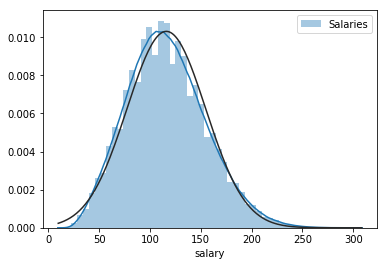

In [ ]:
# Find amount of skewness and kurtosis. Plot distribution curve (blue) next to normal distribution (black).
print('Salary Skewness:', train_data['salary'].skew())
print('Salary Kurtosis:', train_data['salary'].kurt())
print()
if -0.5 <= train_data['salary'].skew() <= 0.5:
    print('Salary distribution is approximately symmetric')
elif -0.5 >  train_data['salary'] > 0.5:
    print('Salary distribution is skewed')

sns.distplot(train_data['salary'], fit=norm, label='Salaries')
plt.legend()

<br>

A regression line will be fit to years experience to visualize it as predictor a of salary.

(0, 315.2775030364004)

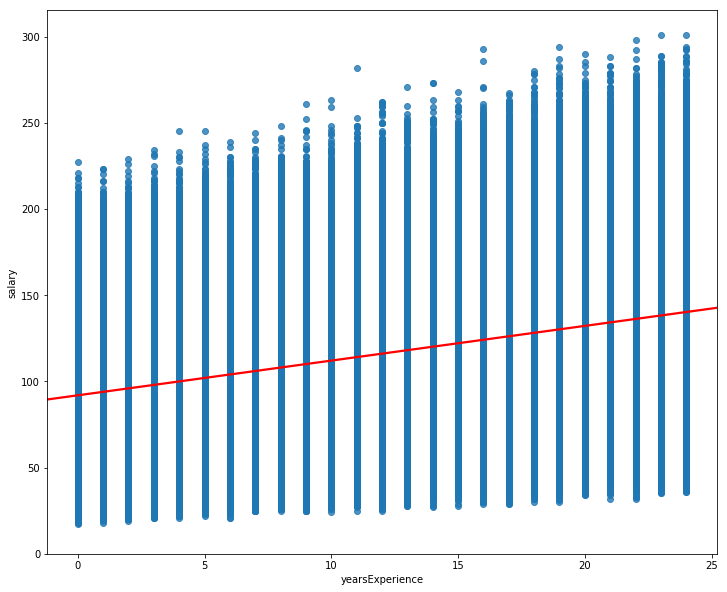

In [ ]:
# Plot regression line on years of experience
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(x='yearsExperience', y='salary', data=train_data, line_kws={'color':'red'})
plt.ylim(0,)

Data is widely spread from regression line and may need to be transformed. A weak positive correlation is also shown.

<br>
Now we will visualize the variance throughout the range of years experience data.

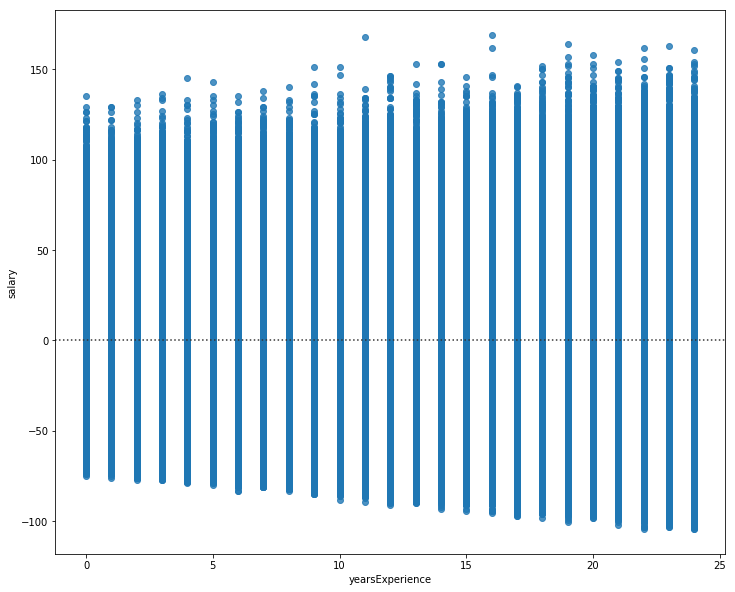

In [ ]:
# Plot variance of years of experience
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.residplot(train_data['yearsExperience'], train_data['salary'])
plt.show()

There is slightly more variance in salary with increased years experience.

<br>
<br>
Now the same visualizations will be applied to miles from metropolis.

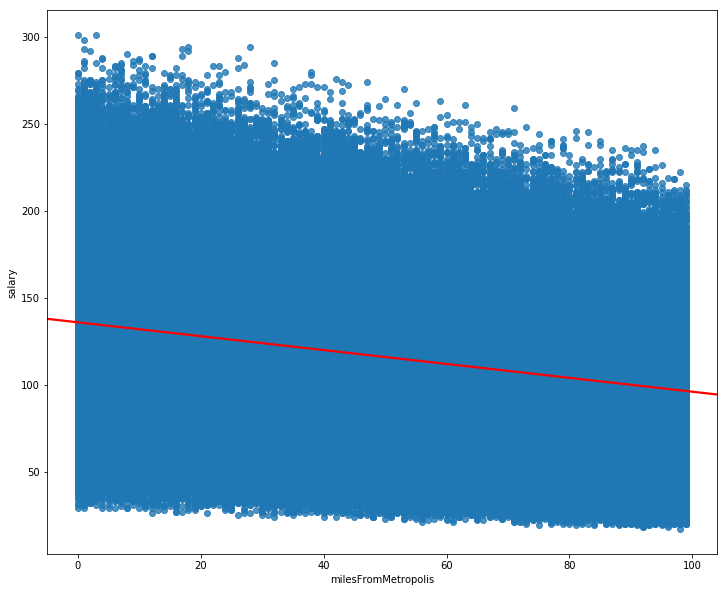

In [ ]:
# Plot regression line on years of experience
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(x='milesFromMetropolis', y='salary', data=train_data, line_kws={'color':'red'})

Data is widely spread from regression line and may need to be transformed. A weak negative correlation is also seen.



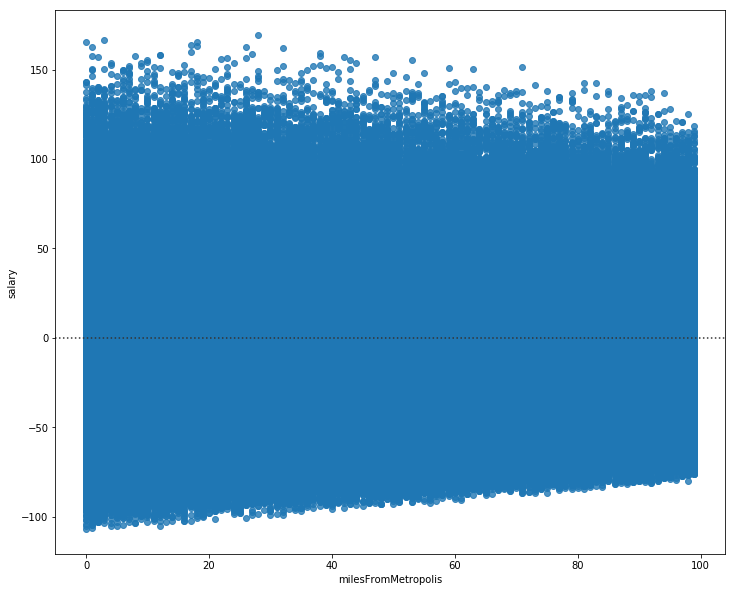

In [ ]:
# Plot variance of miles from metropolis
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.residplot(train_data['milesFromMetropolis'], train_data['salary'])
plt.show()

There is slightly less variance in salaries as miles from metropolis increases.

<br>
<br>
Now we will look at boxplots for each company ID to see if this will be useful for prediction purposes.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 <a list of 63 Text xticklabel objects>)

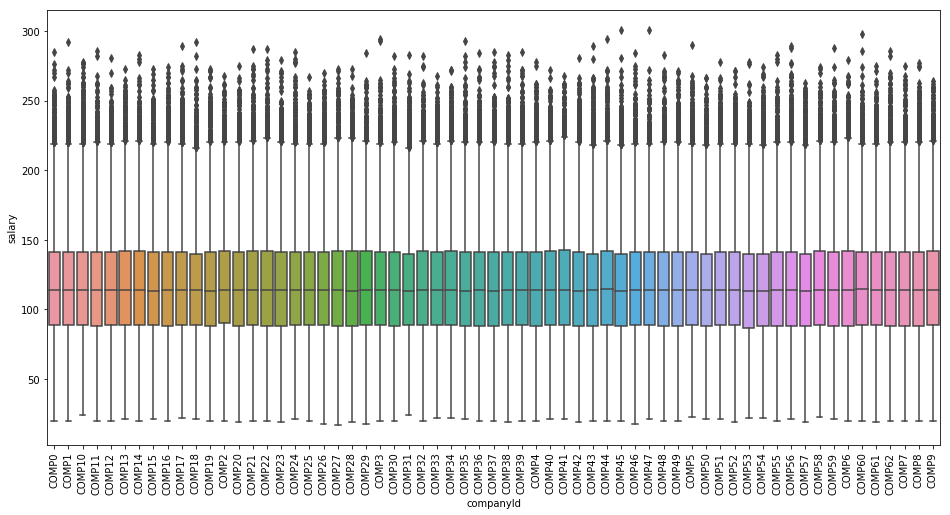

In [ ]:
# Plot boxplots for companyId
width = 16
height = 8
var = 'companyId'
data = pd.concat([train_data['salary'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(width, height))
fig = sns.boxplot(x=var, y='salary', data=data)
plt.xticks(rotation=90)

Company ID shows salaries are evenly distributed from company to company and does not seem to be a good predictor for salary.

<br>
<br>
Job ID and company ID are irrelevant for prediction purposes, so they will be removed from the training data.

In [ ]:
# Remove jobId and companyId
train_data.drop('jobId', axis=1, inplace=True)
train_data.drop('companyId', axis=1, inplace=True)

train_data.head()

jobType       degree      major industry  yearsExperience  \
0             CFO      MASTERS       MATH   HEALTH               10   
1             CEO  HIGH_SCHOOL       NONE      WEB                3   
2  VICE_PRESIDENT     DOCTORAL    PHYSICS   HEALTH               10   
3         MANAGER     DOCTORAL  CHEMISTRY     AUTO                8   
4  VICE_PRESIDENT    BACHELORS    PHYSICS  FINANCE                8   

   milesFromMetropolis  salary  
0                   83     130  
1                   73     101  
2                   38     137  
3                   17     142  
4                   16     163


<br>
<br>
Next, visualizations will be repeated for each categorical feature to see which features may affect salary. Violin plots will be used to view the shape of the distribution curve along with the mean and interquartile ranges.

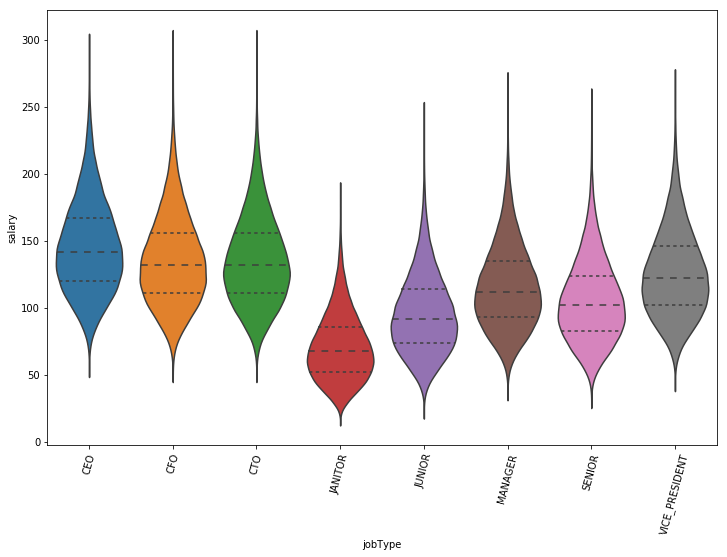

In [ ]:
# jobType violin plot
ViolinPlot(train_data, 'jobType')

The highest salaries are for CEO, followed by CFO and CTO. The lowest is Janitor followed by Junior job types.<br>
Distributions appear normal.

<br>

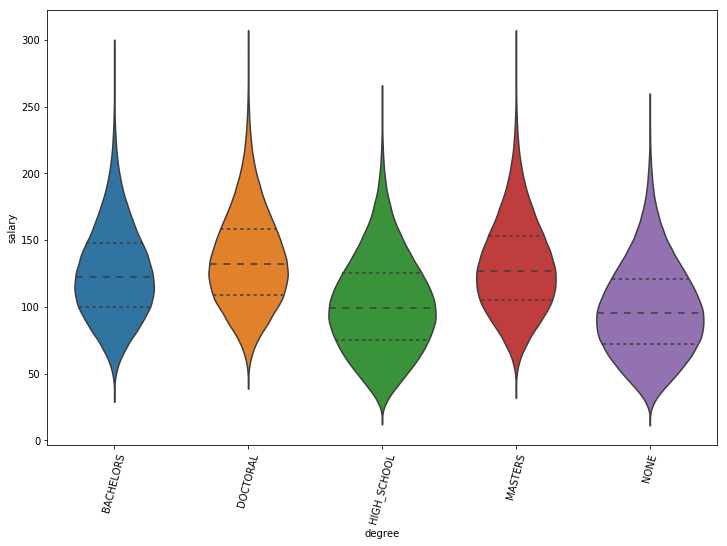

In [ ]:
# degree violin plot
ViolinPlot(train_data,'degree')

Having a college degree seems to give a higher salary than high school or no degree.<br>
Distributions appear normal.
<br>
<br>

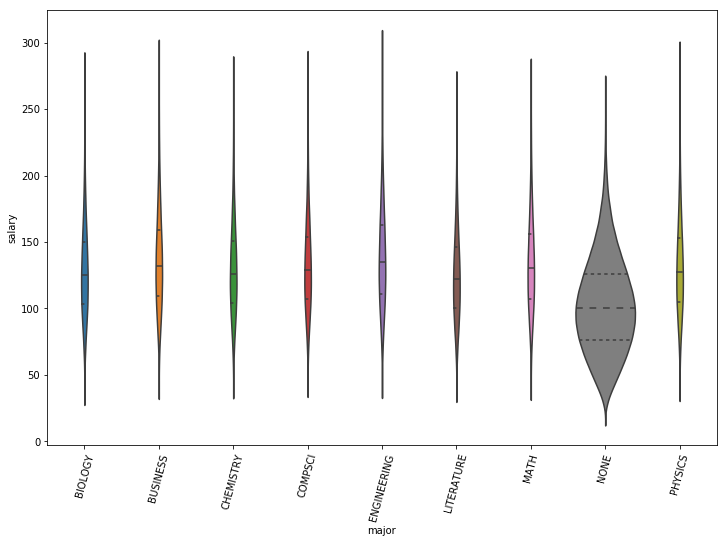

In [ ]:
# major violin plot
ViolinPlot(train_data,'major')

Having no major seems to have lower salaries than having a major. No major may correspond to a high school degree only or no degree at all. <br>
Distributions appear normal.
<br>
<br>

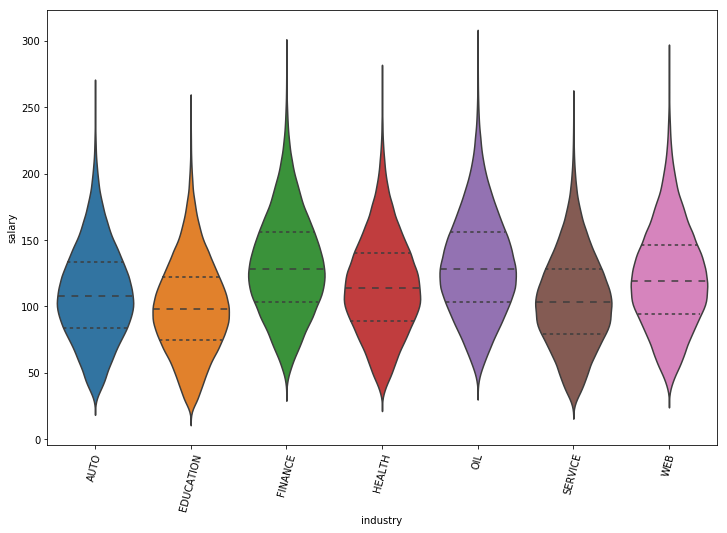

In [ ]:
# Industry violin plot
ViolinPlot(train_data,'industry')

The oil industry, followed by finance and web, seem to have highest salaries. <br>
The education and service industries seem to have the lowest salaries.<br>
Distributions appear normal.
<br>
<br>

Now dummy variables will be assigned to categorical data ("one-hot encoding") so it can be used in the prediction models to be created.

In [ ]:
# One-hot encode categorical data in train_data dataset
train_data= pd.get_dummies(train_data)
train_data.head()

yearsExperience  milesFromMetropolis  salary  jobType_CEO  jobType_CFO  \
0               10                   83     130            0            1   
1                3                   73     101            1            0   
2               10                   38     137            0            0   
3                8                   17     142            0            0   
4                8                   16     163            0            0   

   jobType_CTO  jobType_JANITOR  jobType_JUNIOR  jobType_MANAGER  \
0            0                0               0                0   
1            0                0               0                0   
2            0                0               0                0   
3            0                0               0                1   
4            0                0               0                0   

   jobType_SENIOR      ...       major_MATH  major_NONE  major_PHYSICS  \
0               0      ...                1           0              0   
1               0      ...                0           1              0   
2               0      ...                0           0              1   
3               0      ...                0           0              0   
4               0      ...                0           0              1   

   industry_AUTO  industry_EDUCATION  industry_FINANCE  industry_HEALTH  \
0              0                   0                 0                1   
1              0                   0                 0                0   
2              0                   0                 0                1   
3              1                   0                 0                0   
4              0                   0                 1                0   

   industry_OIL  industry_SERVICE  industry_WEB  
0             0                 0             0  
1             0                 0             1  
2             0                 0             0  
3             0                 0             0  
4             0                 0             0  

[5 rows x 32 columns]

<br>

Now that numerical values are assigned to all features we can see the correlation between all of them.

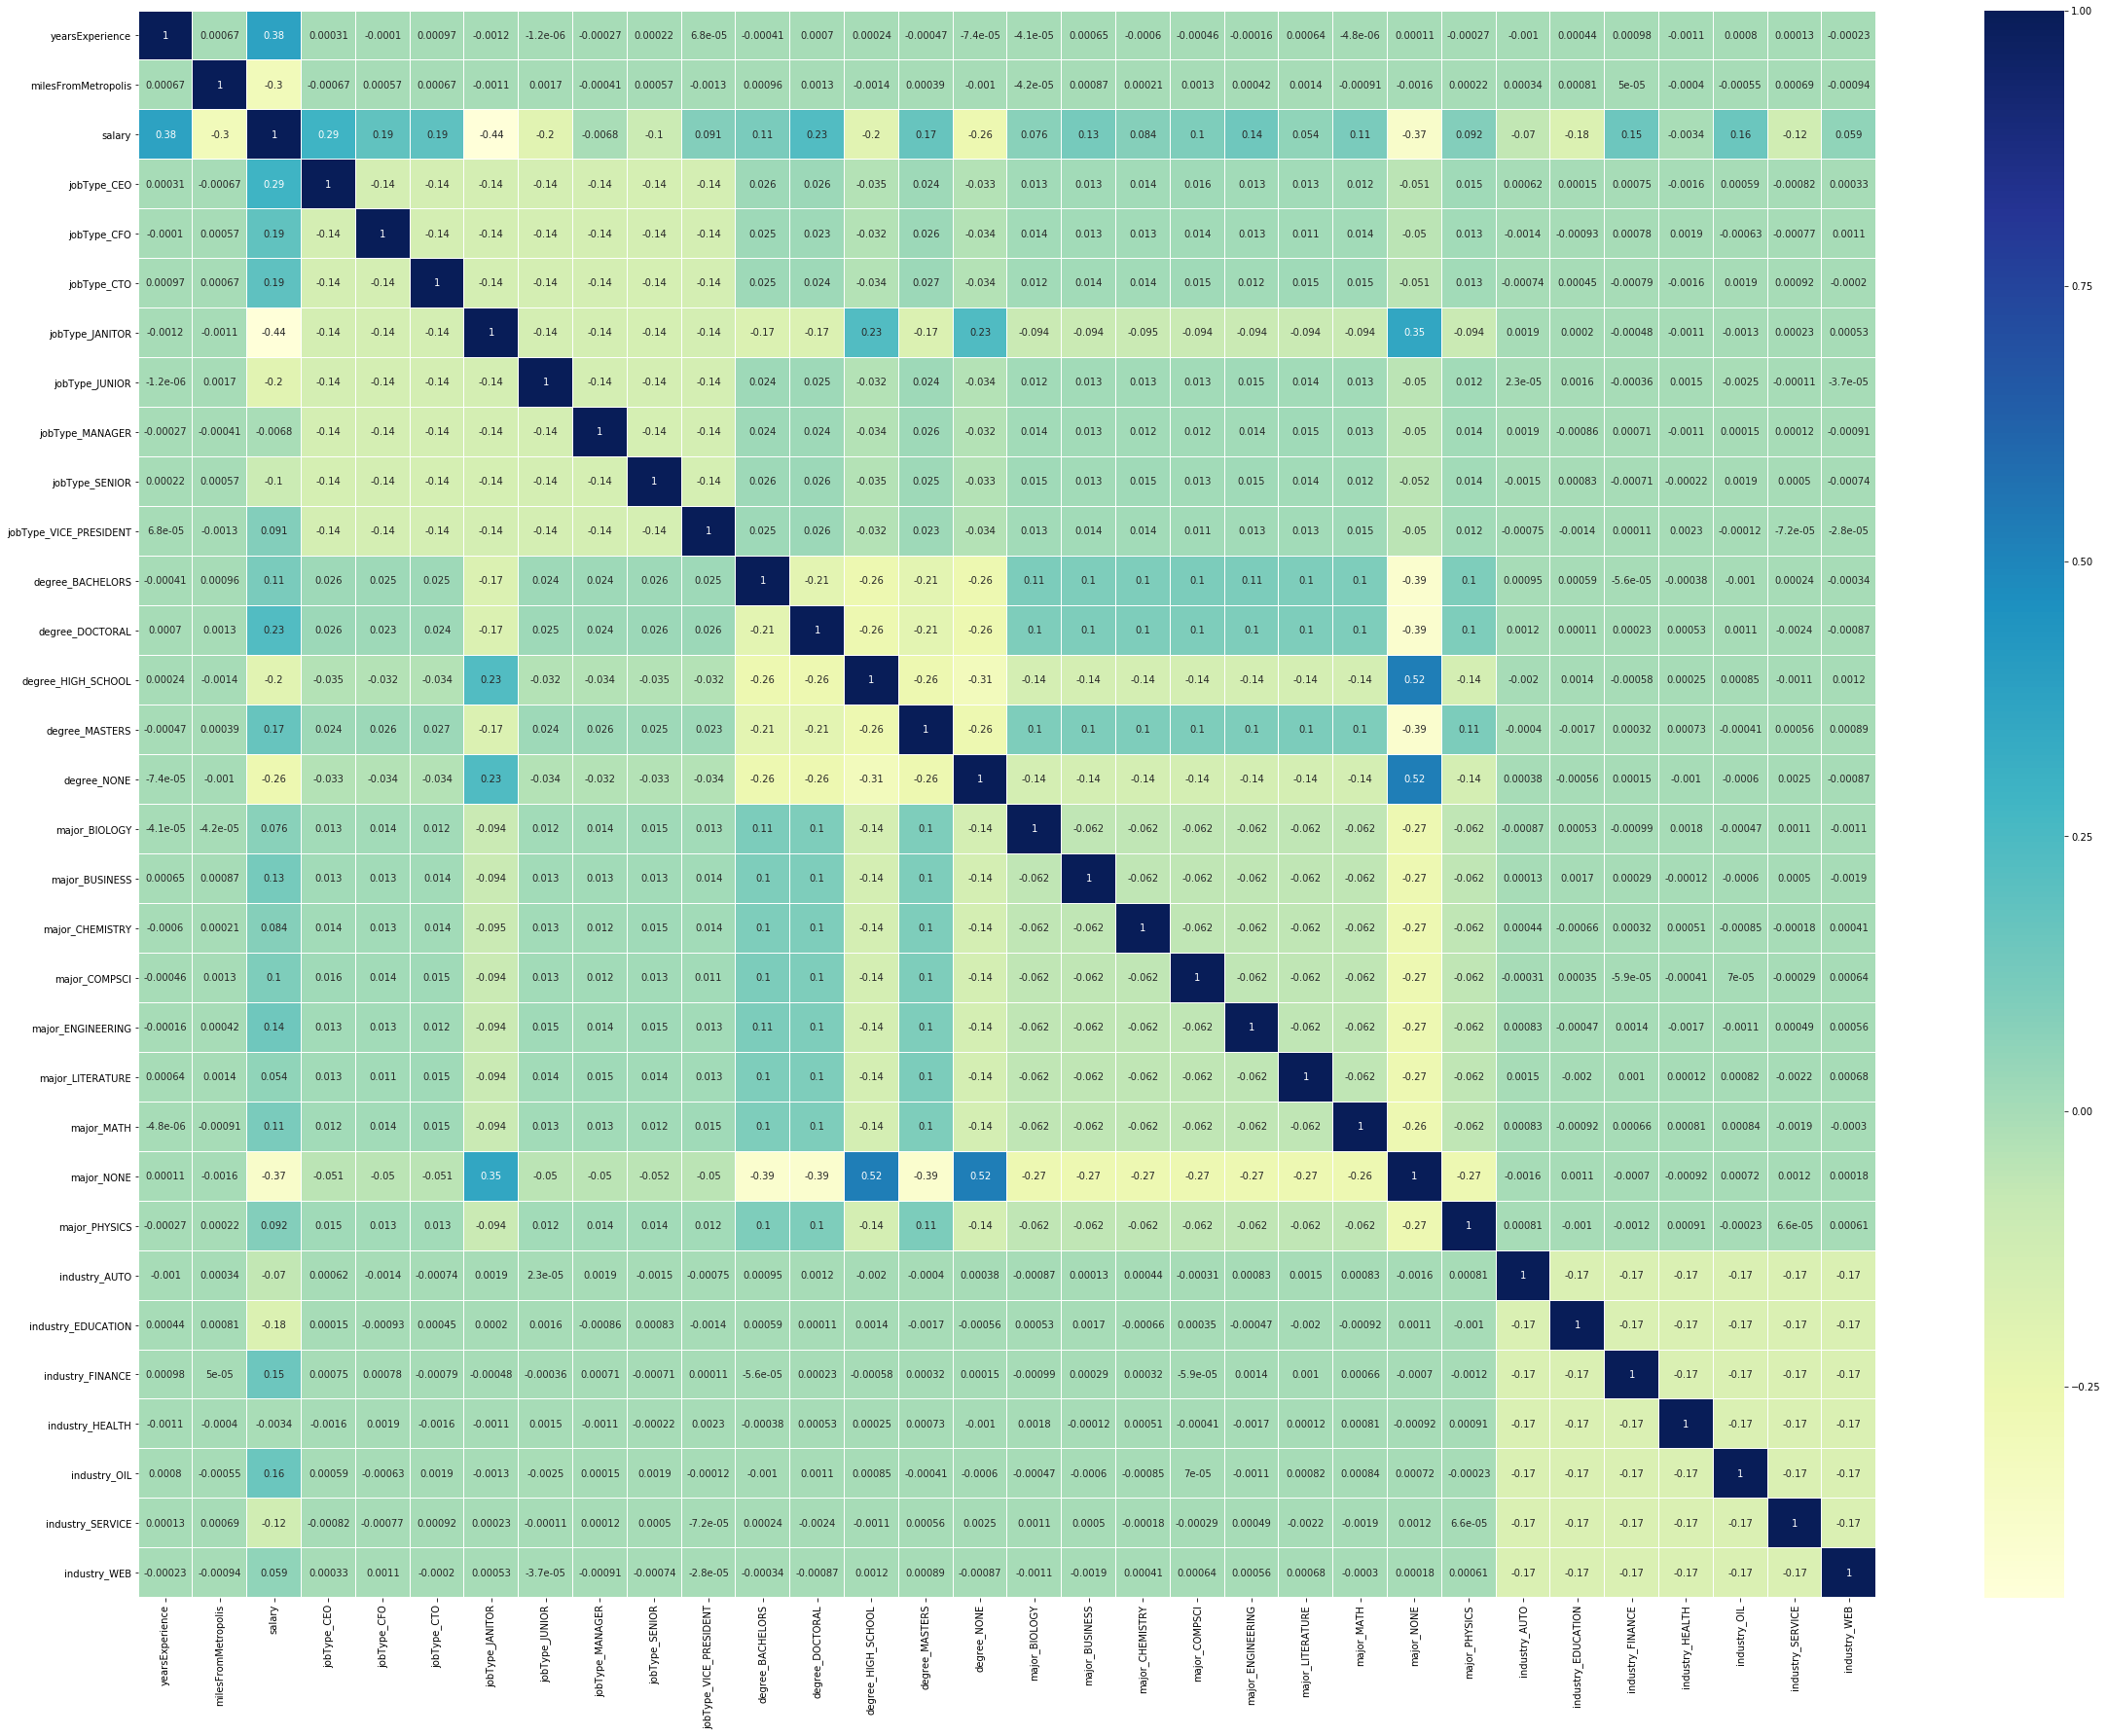

In [ ]:
# Plot heatmap of all data with correlation coefficients visible
train_data_corr = train_data.corr()
plt.subplots(figsize=(40,30))
sns.heatmap(train_data_corr, cmap='YlGnBu', linewidth=.005, annot=True)

Years of experience has highest correlation with salary. Job type also seems to be correlated with salary.

### <u>Establish A Baseline</u>

To create a basic training model x and y variables will be assigned for the model to use. Twenty percent of the training data will be split into testing data so that the model can be tested with data for which the salaries are already known. This will result in the variables X_train, y_train, X_test, and y_test.

In [ ]:
# Assign salary to "y" and all other features to "X". Split into training and testing variables.
X = train_data[train_data.loc[ : , train_data.columns != 'salary'].columns]
y = train_data['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# View inputs and outputs of training variables
print('Inputs: \n', X_train.head())
print('Outputs: \n', y_train.head())

Inputs: 
         yearsExperience  milesFromMetropolis  jobType_CEO  jobType_CFO  \
583582               17                   75            0            0   
465088               14                   88            1            0   
686214               12                   65            0            0   
176612                8                   68            0            0   
249785                3                   13            0            0   

        jobType_CTO  jobType_JANITOR  jobType_JUNIOR  jobType_MANAGER  \
583582            0                0               0                0   
465088            0                0               0                0   
686214            0                0               1                0   
176612            0                0               0                0   
249785            0                0               0                0   

        jobType_SENIOR  jobType_VICE_PRESIDENT      ...       major_MATH  \
583582               0        

<br>


Linear Regression will be used since salaries are a continuous variable. The baseline established will be from applying linear regression to X_train and y_train without altering either variable in any way.

In [ ]:
# Create linear regression object.
lm = LinearRegression()
lm.fit(X_train, y_train)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


View coefficients:

In [ ]:
# View coefficients of linear regression object
print(lm.intercept_)
print(lm.coef_)

-86634823223.50609
[ 2.01083748e+00 -3.99646056e-01  8.04771398e+10  8.04771397e+10
  8.04771397e+10  8.04771397e+10  8.04771397e+10  8.04771397e+10
  8.04771397e+10  8.04771397e+10  5.09177623e+09  5.09177624e+09
  5.09177622e+09  5.09177624e+09  5.09177622e+09  2.70775313e+08
  2.70775321e+08  2.70775314e+08  2.70775317e+08  2.70775324e+08
  2.70775309e+08  2.70775318e+08  2.70775308e+08  2.70775315e+08
  7.95132059e+08  7.95132049e+08  7.95132080e+08  7.95132065e+08
  7.95132080e+08  7.95132054e+08  7.95132071e+08]



Now that the baseline model is created it can predict salaries. The variable yhat will be used for the predictions using the training data.

In [ ]:
# Store linear regression predictions in variable
yhat = lm.predict(X_train)

# View first 5 predictions
print("The output of the first five predicted values are:", yhat[0:5])

The output of the first five predicted values are: [126.75590515 144.06837463  93.90647888 113.80305481 133.2784729 ]


<br>
The mean squared error (MSE) can now be evaluated. MSE will be used along with accuracy and r-squared to evaluate the baseline model and determine if subsequent models have improved over the established baseline.

In [ ]:
# Print MSE of training data
print("The mean squared error of our prediciton model is:", mean_squared_error(y_train, yhat))

The mean squared error of our prediciton model is: 384.2694852161028



The accuracy of the baseline model will also be determined.

In [ ]:
# Print accuracy score using 5-fold cross validation
scores = cross_val_score(lm, X_train, y_train, cv=5)
print("5-Fold Cross Validation Accuracy (train data):", (np.mean(scores)), (np.std(scores)))

5-Fold Cross Validation Accuracy (train data): 0.7433246233006936 0.0005871258620038212


/Users/DJ/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


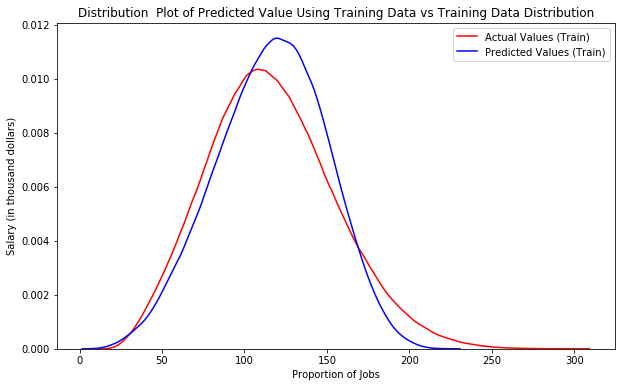

In [ ]:
# View distribution of actual salaries compared to predicted salaries
Title = 'Distribution  Plot of Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat, "Actual Values (Train)", "Predicted Values (Train)", Title)


The predicted and actual salaries are not extremely different. The predicted salaries have a higher mean and lower range.



Next, the same thing will be done with the reserved 20% testing data to see if the outcome is similar.

In [ ]:
# Store linear regression predictions in variable
yhat_test = lm.predict(X_test)

# View first 5 predictions
yhat_test[0:5]

array([157.80125427,  62.36587524, 108.70870972, 112.59100342,
        92.52095032])

In [ ]:
# Print MSE of training data
print("The mean squared error of our test set predicitons is:", mean_squared_error(y_test, yhat_test))

The mean squared error of our test set predicitons is: 384.83003943796683


The MSE for the training and testing data is very close.
<br>
<br>


In [ ]:
# Print accuracy score using 5-fold cross validation
scores = cross_val_score(lm, X_test, y_test, cv=5)
print("5-Fold Cross Validation Accuracy (test data):", (np.mean(scores)), (np.std(scores)))

5-Fold Cross Validation Accuracy (test data): 0.7443984755769636 0.0027138769296562097


/Users/DJ/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


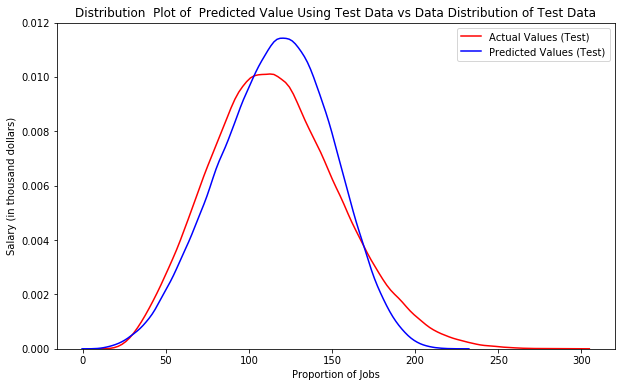

In [ ]:
# View distribution of actual salaries compared to predicted salaries
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

Distribution, accuracy score, and MSE are not incredibly different when comparing the training and testing data.
We will see if MSE can be improved by reducing it to less than 360.

## <u>Hypothesize Solutions</u>

Three  models that may improve results over the baseline model: <br>
<b>1:</b> Apply polynomial transformation<br>
<b>2:</b> Use ridge regression<br>
<b>3:</b> Use random forest<br>

## <u>Engineer Features</u>

The shape and features of the training and testing data will be verified before creating any models with them.

In [ ]:
# View shape and features of all datasets to be used
print("Number of test samples:", X_test.shape, "\nwith these features:\n", X_test.columns)
print("\nNumber of training samples:", X_train.shape, "\nwith these features:\n", X_train.columns)
print("\nNumber of test salaries:", y_test.shape)
print("Number of training salaries:", y_train.shape)

Number of test samples: (199999, 31) 
with these features:
 Index(['yearsExperience', 'milesFromMetropolis', 'jobType_CEO', 'jobType_CFO',
       'jobType_CTO', 'jobType_JANITOR', 'jobType_JUNIOR', 'jobType_MANAGER',
       'jobType_SENIOR', 'jobType_VICE_PRESIDENT', 'degree_BACHELORS',
       'degree_DOCTORAL', 'degree_HIGH_SCHOOL', 'degree_MASTERS',
       'degree_NONE', 'major_BIOLOGY', 'major_BUSINESS', 'major_CHEMISTRY',
       'major_COMPSCI', 'major_ENGINEERING', 'major_LITERATURE', 'major_MATH',
       'major_NONE', 'major_PHYSICS', 'industry_AUTO', 'industry_EDUCATION',
       'industry_FINANCE', 'industry_HEALTH', 'industry_OIL',
       'industry_SERVICE', 'industry_WEB'],
      dtype='object')

Number of training samples: (799996, 31) 
with these features:
 Index(['yearsExperience', 'milesFromMetropolis', 'jobType_CEO', 'jobType_CFO',
       'jobType_CTO', 'jobType_JANITOR', 'jobType_JUNIOR', 'jobType_MANAGER',
       'jobType_SENIOR', 'jobType_VICE_PRESIDENT', 'degree_BACHE

### <u>Create Models</u>

The first solution attempted will be applying polynomial transformation to the linear regression model that was already created to see if error is reduced.

In [ ]:
# Fit and transform the variables using 2nd order polynomial
pr = PolynomialFeatures(2)
X_train_pr = pr.fit_transform(X_train)
X_test_pr = pr.fit_transform(X_test)
pr

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)

In [ ]:
# Create new model using polynomial transformation
poly = LinearRegression()
poly.fit(X_train_pr, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)



View first five preictions using training data:

In [ ]:
yhat_prTrain = poly.predict(X_train_pr)
yhat_prTrain[0:5]

array([122.81038292, 154.60249718,  93.9342614 , 108.47322091,
       124.48774823])



Compare predicted training values to true values:

In [ ]:
print("Predicted Values:", yhat_prTrain[0:5])
print("True Values:", y_test[0:5].values)

Predicted Values: [122.81038292 154.60249718  93.9342614  108.47322091 124.48774823]
True Values: [186  67  82 104 106]




View first five predictions using test data from training dataset:

In [ ]:
yhat_prTest = poly.predict(X_test_pr)
yhat_prTest[0:5]

array([159.44733056,  60.11526497,  96.82036027,  99.60062941,
        93.33856209])



Compare predicted values to true values:

In [ ]:
print("Predicted Values:", yhat_prTest[0:5])
print("True Values:", y_test[0:5].values)

Predicted Values: [159.44733056  60.11526497  96.82036027  99.60062941  93.33856209]
True Values: [186  67  82 104 106]


In [ ]:
print("R-squared of training data:", poly.score(X_train_pr, y_train))
print("R-squared of test data:", poly.score(X_test_pr, y_test))


R-squared of training data: 0.7638922148909846
R-squared of test data: 0.7645110452346376


Minor (.02) improvement over base model

In [ ]:
print("MSE of training data:", mean_squared_error(y_train, yhat_prTrain))
print("MSE of test data:", mean_squared_error(y_test, yhat_prTest))


MSE of training data: 353.5146528542993
MSE of test data: 354.6540319030929



<br>
View distribution of actual vs fitted:


/Users/DJ/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


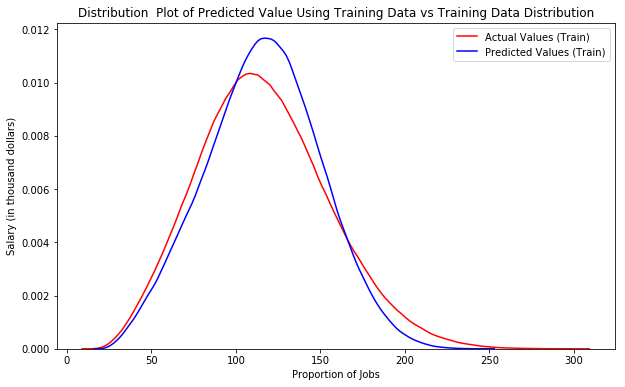

In [ ]:
Title = 'Distribution  Plot of Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat_prTrain, "Actual Values (Train)", "Predicted Values (Train)", Title)


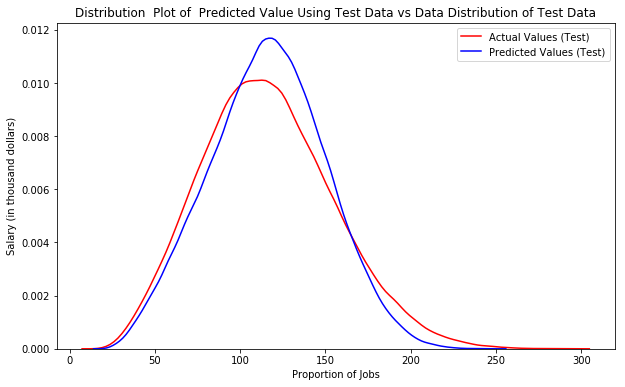

In [ ]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_prTest,"Actual Values (Test)","Predicted Values (Test)",Title)



<br>
<br>
See if applying ridge regression gets lower MSE:

In [ ]:

RidgeModel = Ridge(alpha=1.0)

In [ ]:
RidgeModel.fit(X_train_pr, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)



Predict values:

In [ ]:
yhat_ridge_train = RidgeModel.predict(X_train_pr)
yhat_ridge_test = RidgeModel.predict(X_test_pr)



Compare predicted train values to actual values:

In [ ]:
print('Predicted:', yhat_ridge_train[0:4])
print('Actual :', y_train[0:4].values)

Predicted: [122.80535226 154.60016552  93.93272274 108.47222045]
Actual : [ 90 164  87 126]




Compare predicted test values to actual values:

In [ ]:
print('Predicted:', yhat_ridge_test[0:4])
print('Actual :', y_test[0:4].values)

Predicted: [159.45593431  60.11135936  96.82007354  99.5978305 ]
Actual : [186  67  82 104]


In [ ]:
print("R-squared of training data:", RidgeModel.score(X_train_pr, y_train))
print("R-squared of test data:", RidgeModel.score(X_test_pr, y_test))
# No significant improvement

R-squared of training data: 0.7638922261902712
R-squared of test data: 0.7645108187953095


In [ ]:
print("MSE of training data:", mean_squared_error(y_train, yhat_ridge_train))
print("MSE of test data:", mean_squared_error(y_test, yhat_ridge_test))


MSE of training data: 353.5146359363337
MSE of test data: 354.6543729280925


No improvement using alpha [0.1, 1.0, 10.0, 100.0, 1000.0]


<br>

Use gridsearch to ensure best hyperparameter was used:

In [ ]:
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
parameters1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]



Create new ridge regression object:

In [ ]:
RR = Ridge()
RR

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


Create ridge grid search object and fit:

In [ ]:
Grid1 = GridSearchCV(RR, parameters1, cv=5)

In [ ]:
Grid1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)



Assign best estimator:

In [ ]:
bestRR = Grid1.best_estimator_
bestRR

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Test model using test data from training dataset:

In [ ]:
bestRR.score(X_test, y_test)


0.7444743887739421

No improvement using alpha = 1.0


<br>
Instantiate and fit random forest model with random_state=1 for consistency:


In [ ]:
rf = RandomForestRegressor(n_estimators=1000, random_state=1)

In [ ]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)



View predictions:

In [ ]:
predictions = rf.predict(X_test)
predictions[0:5]

array([170.5755    ,  61.15505238,  90.37748333,  98.5285    ,
       106.54405   ])

In [ ]:
print("R-squared of test data:", rf.score(X_test, y_test))
print("MSE of test data:", mean_squared_error(y_test, predictions))

R-squared of test data: 0.707887081666257
MSE of test data: 439.9315643541132


## <u>Summary and Best Model</u>

Linear regression with second order polynomial transformation gave best predictions with MSE of 354 and accuracy of 76%. This meets the goal of reducing MSE to below 360 and will be used as a minimum viable product.

Ridge regression had similar results to the baseline model and random forest performed worse with an MSE close to 440 and an accuracy of 70%.

## Automate and Deploy Model

### <u>Automate Pipeline</u>

To deploy the selected model a data pipeline will be created to automate the needed transformations once data is given as an input to the model.


In [ ]:
# Create pipeline for polynomial regression
Input = [('scale', StandardScaler()), ('polynomial', PolynomialFeatures(include_bias=False)), ('model', LinearRegression())]
pipe = Pipeline(Input)
pipe

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomial', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [ ]:
polyLRModel =  pipe.fit(X, y)

/Users/DJ/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/DJ/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)





Normalize, transform, and produce predictions:

In [ ]:
ypipe = pipe.predict(X)
ypipe[0:5]

/Users/DJ/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


array([126.92382812, 116.16992188, 134.65039062, 121.4453125 ,
       142.23632812])

<br>

Now the model will be saved so it can be used whenever needed.

In [ ]:
filename = 'final_salary_model.csv'
joblib.dump(polyLRModel, filename)

['final_salary_model.csv']

<br>
The model can now be loaded into a variable and have new data loaded into it.

In [ ]:
# Load model
loaded_model = joblib.load(filename)

In [ ]:
# See result of test data with known salaries
result = loaded_model.score(X_test, y_test)
print(result)

/Users/DJ/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.764619788276611


### <u>Deploy Solution</u>

Prepare test data:

In [ ]:
# Load new data into dataframe
test_feat = pd.DataFrame(test_feat)

# Convert features to same types used in model
test_feat['jobId']=pd.Categorical(test_feat['jobId'])
test_feat['companyId']=pd.Categorical(test_feat['companyId'])
test_feat['jobType']=pd.Categorical(test_feat['jobType'])
test_feat['degree']=pd.Categorical(test_feat['degree'])
test_feat['major']=pd.Categorical(test_feat['major'])
test_feat['industry']=pd.Categorical(test_feat['industry'])

# Drop features not relevant to salary prediction
test_feat.drop('jobId', axis=1, inplace=True)
test_feat.drop('companyId', axis=1, inplace=True)

# One-hot encode categorical data
test_feat = pd.get_dummies(test_feat)

# View top 5 rows of data
test_feat.head(5)

yearsExperience  milesFromMetropolis  jobType_CEO  jobType_CFO  \
0               22                   73            0            0   
1               20                   47            0            0   
2               17                    9            0            0   
3               14                   96            0            0   
4               10                   44            0            0   

   jobType_CTO  jobType_JANITOR  jobType_JUNIOR  jobType_MANAGER  \
0            0                0               0                1   
1            0                0               1                0   
2            1                0               0                0   
3            0                0               0                1   
4            0                0               1                0   

   jobType_SENIOR  jobType_VICE_PRESIDENT      ...       major_MATH  \
0               0                       0      ...                0   
1               0                       0      ...                0   
2               0                       0      ...                0   
3               0                       0      ...                0   
4               0                       0      ...                0   

   major_NONE  major_PHYSICS  industry_AUTO  industry_EDUCATION  \
0           1              0              0                   0   
1           1              0              1                   0   
2           0              0              0                   0   
3           1              0              0                   0   
4           0              0              0                   0   

   industry_FINANCE  industry_HEALTH  industry_OIL  industry_SERVICE  \
0                 0                1             0                 0   
1                 0                0             0                 0   
2                 0                1             0                 0   
3                 0                0             1                 0   
4                 0                0             1                 0   

   industry_WEB  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 31 columns]

<br>

Now that some minimal data cleansing has been done to the test data with no corresponding salaries, it it ready to be input into the saved linear regression model so that salaries can be predicted. This test data will simulate real world data that salaries need to be predicted for.

In [ ]:
# Predict salaries from new data
loaded_model.predict(test_feat)

/Users/DJ/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


array([111.19335938,  93.07226562, 182.90039062, ...,  54.96289062,
       161.41601562, 112.29101562])

### <u>Measure Efficacy</u>

This step not completed since there are no outcomes for the test data.

## Summary

Applying second order polynomial transformation to the features gave the most accurate predictions with the least error when using a linear regression model. The result was a mean squared error of 354 with a 76% accuracy rate.

This model can be used as a guide when determining salaries since it shows reasonable predictions when given information on years of experience, miles from metropolis, job type, industry, and college degree and major.